**SENTIMENT ANALYSIS OF CUSTOMER REVIEWS USING VADER AND RoBERTa
(**valency aware dictionary and sentiment reasoner/ pretrained transformer)

GOAL- Understand how these approaches can predict sentiments and uncover their strengths and weaknesses.

In [ ]:
!pip install pyspellchecker
!pip install unidecode

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from io import StringIO
import sqlite3
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from tqdm.notebook import tqdm
from unidecode import unidecode
from spellchecker import SpellChecker
from nltk.tag import pos_tag
from collections import Counter
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
plt.style.use("ggplot")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2>Data Preparation: Loading Data from csv file, handling exceptions for parsing issues. Valid rows are stored in a DataFrame named 'df'.

In [ ]:
# Initialize an empty list to store problematic row IDs
problematic_row_ids = []

# Read the CSV file line by line and handle exceptions
data = []
with open('Review.csv', 'r', encoding='utf-8') as file:
    for i, line in enumerate(file):
        try:
            # Attempt to parse the line as a CSV row
            pd.read_csv(StringIO(line), encoding='utf-8')
            data.append(line)
        except pd.errors.ParserError:
            # If an exception occurs, record the problematic row ID
            problematic_row_ids.append(i)

# Create a DataFrame from the valid rows
df = pd.read_csv(StringIO('\n'.join(data)), encoding='utf-8')

# Now, the DataFrame 'df' contains all the valid rows from the CSV file,
# and the list 'problematic_row_ids' contains the row IDs with parsing issues.


In [ ]:
problematic_row_ids

[]

In [ ]:
df.shape

(4999, 3)

In [ ]:
# Displaying the distribution of values in the 'Score' column
df['Score'].value_counts()

5    1001
3    1000
4    1000
1     999
2     999
Name: Score, dtype: int64

In [ ]:
# Data Cleaning:
# Define a function to handle illegal characters in strings doesn't have a visual representation (e.g., newline, tab, etc.).
def clean_string(x):
    if isinstance(x, str):
        return ''.join(c for c in x if c.isprintable())
    return x

# Apply the 'clean_string' function to string-type columns in the DataFrame
df = df.applymap(clean_string)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      4999 non-null   int64 
 1   Score   4999 non-null   int64 
 2   Text    4999 non-null   object
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


In [ ]:
df['Score'].value_counts()

5    1001
3    1000
4    1000
1     999
2     999
Name: Score, dtype: int64

In [ ]:
df.head()

,Id,Score,Text
0,2,1,Product arrived labeled as Jumbo Salted Peanut...
1,13,1,My cats have been happily eating Felidae Plati...
2,27,1,"The candy is just red , No flavor . Just plan..."
3,51,1,"This oatmeal is not good. Its mushy, soft, I d..."
4,63,1,Arrived in 6 days and were so stale i could no...


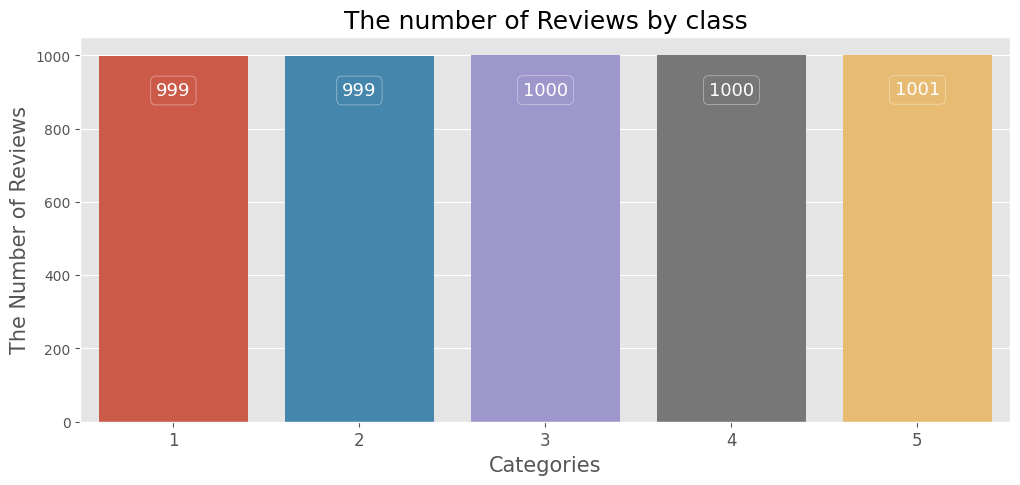

In [ ]:
# Bar plot for each of the new category
category_count = df['Score'].value_counts()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

sns.barplot(x=category_count.index, y=category_count)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), xy=(p.get_x() + p.get_width() / 2.0, p.get_height()),
                xytext=(0, -25), size=13, color='white', ha='center', va='center',
                textcoords='offset points', bbox=dict(boxstyle='round', facecolor='none', edgecolor='white', alpha=0.5))

plt.xlabel('Categories', size=15)
plt.ylabel('The Number of Reviews', size=15)
plt.xticks(size=12)
plt.title("The number of Reviews by class", size=18)
plt.show()


## Dataset Overview

### Columns

1. **Id:** Amazon review ID.
2. **Score:** Score of the review (ranging from 1 to 5, where 1 is the lowest rating and 5 is the highest rating).
3. **Text:** Amazon review given by customers.

### Classes and Shape

- There are five unique classes in the dataset, labeled 1 to 5.

### Shape

- The dataset contains 4999 records.

### Distribution

- Each class has approximately equal number of records.

### Balance

- The dataset is relatively balanced in terms of the number of records per class.

### Null Values

- There are no null values in the dataset.

### Duplicates

- There are no duplicates in the dataset.



**Exploratory data analysis**

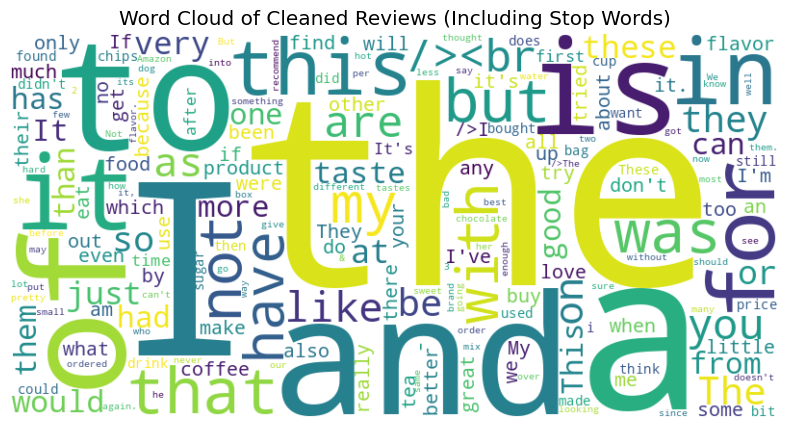

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all cleaned reviews into a single text
all_reviews_text = ' '.join(df['Text'])

# Generate word frequencies
word_frequencies = {}

# Split the text into words
words = all_reviews_text.split()

# Count the frequency of each word
for word in words:
    if word in word_frequencies:
        word_frequencies[word] += 1
    else:
        word_frequencies[word] = 1

# Generate a word cloud using the word frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white' ,stopwords=None).generate_from_frequencies(word_frequencies)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Reviews (Including Stop Words)")
plt.show()


In [ ]:

# Sort the word frequencies dictionary by values in descending order
sorted_word_freq = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)

# Create a list of tuples containing word and frequency
unique_words_with_freq = [(word, freq) for word, freq in sorted_word_freq]

# Calculate the total count of unique words
total_unique_words = len(unique_words_with_freq)

# Create a DataFrame from the unique words and frequencies
unique_words_df = pd.DataFrame(unique_words_with_freq, columns=['Word', 'Frequency'])

# Save the DataFrame to an Excel file
# output_excel_unique_words = 'unique_words.xlsx'
# unique_words_df.to_excel(output_excel_unique_words, index=False)
# print(f"Unique words and frequencies saved to {output_excel_unique_words}")

# Print the total count of unique words
print(f"Total Count of Unique Words: {total_unique_words}")


Total Count of Unique Words: 36398


In [ ]:

# Prie_words}")nt the top 5000 most frequent words
print("Top 100 Most Frequent Words:")
for i, (word, freq) in enumerate(unique_words_with_freq[:100]):
    print(f"{i+1}. Word: {word}, Frequency: {freq}")

Top 100 Most Frequent Words:
1. Word: the, Frequency: 16216
2. Word: I, Frequency: 12991
3. Word: a, Frequency: 10807
4. Word: and, Frequency: 10590
5. Word: to, Frequency: 9175
6. Word: of, Frequency: 7851
7. Word: is, Frequency: 6443
8. Word: it, Frequency: 6126
9. Word: in, Frequency: 4700
10. Word: for, Frequency: 4583
11. Word: this, Frequency: 4581
12. Word: that, Frequency: 3848
13. Word: but, Frequency: 3432
14. Word: not, Frequency: 3390
15. Word: was, Frequency: 3337
16. Word: with, Frequency: 3197
17. Word: my, Frequency: 2837
18. Word: have, Frequency: 2781
19. Word: /><br, Frequency: 2751
20. Word: are, Frequency: 2748
21. Word: you, Frequency: 2452
22. Word: as, Frequency: 2391
23. Word: like, Frequency: 2354
24. Word: on, Frequency: 2239
25. Word: The, Frequency: 2021
26. Word: be, Frequency: 1948
27. Word: they, Frequency: 1867
28. Word: so, Frequency: 1787
29. Word: or, Frequency: 1609
30. Word: at, Frequency: 1547
31. Word: just, Frequency: 1455
32. Word: these, Frequ

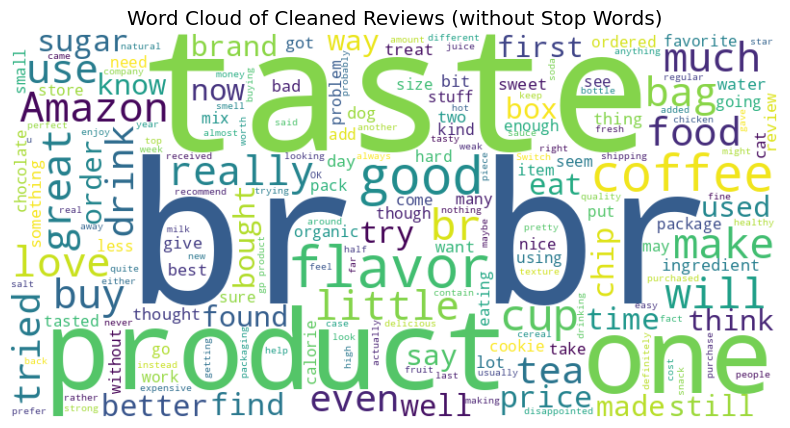

In [ ]:
# Combine all cleaned reviews into a single text
all_reviews_text = ' '.join(df['Text'])

# Generate a word cloud using the entire text (including stop words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Reviews (without Stop Words)")
plt.show()
# Combine all cleaned reviews into a single text
all_reviews_text = ' '.join(df['Text'])  # Use 'Text' column name



**BASIC Nltk**

In [ ]:
example = df['Text'][50]
print(example)

Don't waste your money on any of the Kettle brand potato chips.  I bought a case of these, and a case of the cheddar and sour cream.  Both cases ended up in the garbage can.


lets see what Nltk can do out of the box

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

# To perform sentence tokenization using NLTK, you can use the sent_tokenize function from the nltk.tokenize module. Here's the code for sentence tokenization:
# Perform sentence tokenization

sentences = nltk.sent_tokenize(example)

# Print the result
sentences

["Don't waste your money on any of the Kettle brand potato chips.",
 'I bought a case of these, and a case of the cheddar and sour cream.',
 'Both cases ended up in the garbage can.']

In [ ]:
tokens = nltk.word_tokenize(example)
# tokens[:10]
tokens

['Do',
 "n't",
 'waste',
 'your',
 'money',
 'on',
 'any',
 'of',
 'the',
 'Kettle',
 'brand',
 'potato',
 'chips',
 '.',
 'I',
 'bought',
 'a',
 'case',
 'of',
 'these',
 ',',
 'and',
 'a',
 'case',
 'of',
 'the',
 'cheddar',
 'and',
 'sour',
 'cream',
 '.',
 'Both',
 'cases',
 'ended',
 'up',
 'in',
 'the',
 'garbage',
 'can',
 '.']

**Part-of-Speech (POS) Tagging Analysis**
Use POS tagging to categorize words into different grammatical parts of speech (e.g., nouns, verbs, adjectives) and analyze their distribution and patterns.

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# finiding parts of speech for these tockens
tagged = nltk.pos_tag(tokens)
tagged

[('Do', 'VBP'),
 ("n't", 'RB'),
 ('waste', 'VB'),
 ('your', 'PRP$'),
 ('money', 'NN'),
 ('on', 'IN'),
 ('any', 'DT'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('Kettle', 'NNP'),
 ('brand', 'NN'),
 ('potato', 'NN'),
 ('chips', 'NNS'),
 ('.', '.'),
 ('I', 'PRP'),
 ('bought', 'VBD'),
 ('a', 'DT'),
 ('case', 'NN'),
 ('of', 'IN'),
 ('these', 'DT'),
 (',', ','),
 ('and', 'CC'),
 ('a', 'DT'),
 ('case', 'NN'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('cheddar', 'NN'),
 ('and', 'CC'),
 ('sour', 'JJ'),
 ('cream', 'NN'),
 ('.', '.'),
 ('Both', 'DT'),
 ('cases', 'NNS'),
 ('ended', 'VBD'),
 ('up', 'RP'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('garbage', 'NN'),
 ('can', 'MD'),
 ('.', '.')]

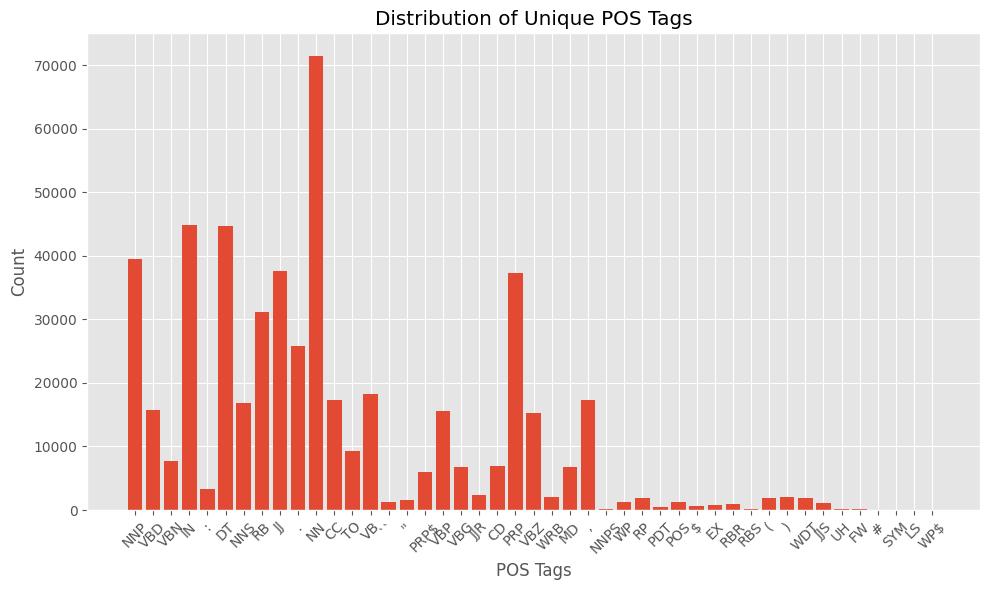

                                                   Text  \
0     Product arrived labeled as Jumbo Salted Peanut...   
1     My cats have been happily eating Felidae Plati...   
2     The candy is just red , No flavor . Just  plan...   
3     This oatmeal is not good. Its mushy, soft, I d...   
4     Arrived in 6 days and were so stale i could no...   
...                                                 ...   
4994  WE LOVE LOVE LOVE these muffins. They are mois...   
4995  I brought 2 bottles.  One I carry in my pocket...   
4996  I really like this soup.  It is mild and I don...   
4997  This is quick, easy and portable, and I think ...   
4998  We ordered a pack of these and ate through the...   

                                           noun_phrases  \
0     [Product, Jumbo, Salted, Peanuts, peanuts, err...   
1     [cats, Felidae, Platinum, years, bag, shape, f...   
2                    [candy, flavor, Just, plan, chewy]   
3                   [oatmeal, mushy, Quaker, Oats, way]

In [ ]:

# Tokenize the text in each row of the DataFrame
df['tokens'] = df['Text'].apply(word_tokenize)

# Perform POS tagging for each row
df['tagged_tokens'] = df['tokens'].apply(pos_tag)

# Count the distribution of unique POS tags across the entire DataFrame
all_pos_counts = Counter(tag for tagged_tokens in df['tagged_tokens'] for word, tag in tagged_tokens)

# Extract unique POS tags and corresponding counts for plotting
pos_tags = list(all_pos_counts.keys())
tag_counts = list(all_pos_counts.values())

# Create a bar plot of unique POS tag distribution
plt.figure(figsize=(10, 6))
plt.bar(pos_tags, tag_counts)
plt.xlabel('POS Tags')
plt.ylabel('Count')
plt.title('Distribution of Unique POS Tags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze patterns (if needed)
def extract_noun_phrases(tagged_tokens):
    return [word for word, tag in tagged_tokens if tag.startswith('N')]

def extract_verb_phrases(tagged_tokens):
    return [word for word, tag in tagged_tokens if tag.startswith('V')]

df['noun_phrases'] = df['tagged_tokens'].apply(extract_noun_phrases)
df['verb_phrases'] = df['tagged_tokens'].apply(extract_verb_phrases)

# Display the DataFrame with extracted noun and verb phrases
print(df[['Text', 'noun_phrases', 'verb_phrases']])


In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
# Taking from here we can put entities
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  Do/VBP
  n't/RB
  waste/VB
  your/PRP$
  money/NN
  on/IN
  any/DT
  of/IN
  the/DT
  (GPE Kettle/NNP)
  brand/NN
  potato/NN
  chips/NNS
  ./.
  I/PRP
  bought/VBD
  a/DT
  case/NN
  of/IN
  these/DT
  ,/,
  and/CC
  a/DT
  case/NN
  of/IN
  the/DT
  cheddar/NN
  and/CC
  sour/JJ
  cream/NN
  ./.
  Both/DT
  cases/NNS
  ended/VBD
  up/RP
  in/IN
  the/DT
  garbage/NN
  can/MD
  ./.)


VADER Sentiment Analysis: we use the VADER sentiment analysis tool to calculate polarity scores for each review, including negative, neutral, positive, and compound scores.
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment analysis tool that was developed as part of the Natural Language Toolkit (NLTK), which is a popular Python library for working with human language data. However, it's important to note that VADER is not included directly within NLTK itself; rather, it's available as an extension or add-on to NLTK.

VADER stands for "Valence Aware Dictionary and sEntiment Reasoner." It is a lexicon and rule-based sentiment analysis tool . VADER incorporates a pre-built lexicon of words and phrases with associated sentiment scores, as well as rules that account for linguistic and contextual factors that can influence sentiment.

VADER's design and internal mechanisms take care of the linguistic aspects, which means that you don't need to explicitly perform tokenization, part-of-speech tagging, or other linguistic analysis steps that we just saw above before using VADER. You can directly input your text to the VADER tool or library, and it will handle the sentiment analysis for you.

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Step 1. VADER Seniment Scoring
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:
Stop words are removed
each word is scored and combined to a total score.

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

Detailed breakdown of compound score ranges:

Extreme Negative: Compound score < -0.9
Very Negative: -0.9 <= Compound score < -0.6
Negative: -0.6 <= Compound score < -0.3
Slightly Negative: -0.3 <= Compound score < -0.05
Neutral: -0.05 <= Compound score <= 0.05
Slightly Positive: 0.05 < Compound score <= 0.3
Positive: 0.3 < Compound score <= 0.6
Very Positive: 0.6 < Compound score <= 0.9
Extreme Positive: Compound score > 0.9

In [ ]:
print(example)
sia.polarity_scores(example)


Don't waste your money on any of the Kettle brand potato chips.  I bought a case of these, and a case of the cheddar and sour cream.  Both cases ended up in the garbage can.


{'neg': 0.0, 'neu': 0.93, 'pos': 0.07, 'compound': 0.3252}

In [ ]:
# analysing negative satment polarity score
sia.polarity_scores('This is the worst thing ever.')


{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

Step 3. Roberta Pretrained Model
Use a model trained of a large corpus of data.
Transformer model accounts for the words but also the context related to other words.


The "cardiffnlp/twitter-roberta-base-sentiment" model is a variant of the RoBERTa model fine-tuned specifically for sentiment analysis on Twitter data. RoBERTa is a highly effective language representation model based on the transformer architecture. The "twitter-roberta-base-sentiment" variant is fine-tuned to classify text into sentiment categories, such as positive, negative, or neutral, typically using three output nodes.

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

check for VADER sentiment analysis and Roberta results on our random selected text fro our dataset

In [ ]:
def comparescores(text):
    # VADER results  example
    print(text)
    print('vader polarity score',sia.polarity_scores(text))


    # Run for Roberta Model
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    print('RoBERTa score',scores_dict)
    scores

print('---------------------case randomly selected from dataset---------------------' )
comparescores(example)
print('')
print('---------------------case 1 using doesnot---------------------' )
example1 = ' it doesnot deliver on its promises.'
comparescores(example1)
print()
print('---------------------case 2 using doesn\'t---------------------' )
example2 = ' it doesn\'t deliver on its promises.'
comparescores(example2)
print()
print('---------------------case 3 negative---------------------' )
example3 = 'I had high hopes for this product, but it turned out to be a big letdown'
comparescores(example3)
print()
print('---------------------case 4---------------------' )
example4 = 'I had high hopes for this product,it turned out to be a big letdown'
comparescores(example4)
print()
print('---------------------case 6 positive---------------------' )
example6 = 'I can confidently say that this product has exceeded my expectationss'
comparescores(example6)
print()
print('---------------------case 7 simple positve---------------------' )
example7 = 'this product is great'
comparescores(example7)
print()
print('---------------------case 7 simple negative---------------------' )
example8 = 'this product is bad'
comparescores(example8)
print()
print('---------------------# Sarcastic review1---------------------' )
sarcastic_review = "Oh boy, where do I even start with this amazing product? It's so mind-blowingly ineffective that I can hardly contain my excitement. If you're into wasting money on things that barely qualify as 'products,' then this is your golden ticket."
comparescores(sarcastic_review)
print()
print('---------------------# Sarcastic review 2 ---------------------' )
example5 = 'I wish I could give this product zero stars'
comparescores(example5)
print()

---------------------case randomly selected from dataset---------------------
Don't waste your money on any of the Kettle brand potato chips.  I bought a case of these, and a case of the cheddar and sour cream.  Both cases ended up in the garbage can.
vader polarity score {'neg': 0.0, 'neu': 0.93, 'pos': 0.07, 'compound': 0.3252}
RoBERTa score {'roberta_neg': 0.91993785, 'roberta_neu': 0.072001815, 'roberta_pos': 0.008060263}

---------------------case 1 using doesnot---------------------
 it doesnot deliver on its promises.
vader polarity score {'neg': 0.0, 'neu': 0.658, 'pos': 0.342, 'compound': 0.3818}
RoBERTa score {'roberta_neg': 0.8377977, 'roberta_neu': 0.15281548, 'roberta_pos': 0.009386818}

---------------------case 2 using doesn't---------------------
 it doesn't deliver on its promises.
vader polarity score {'neg': 0.0, 'neu': 0.658, 'pos': 0.342, 'compound': 0.3818}
RoBERTa score {'roberta_neg': 0.85143805, 'roberta_neu': 0.14045037, 'roberta_pos': 0.008111495}

----------

<h2>Sentiment Analysis on the complete Test Data using both techniques and then comparing the outcomes of both</h2>


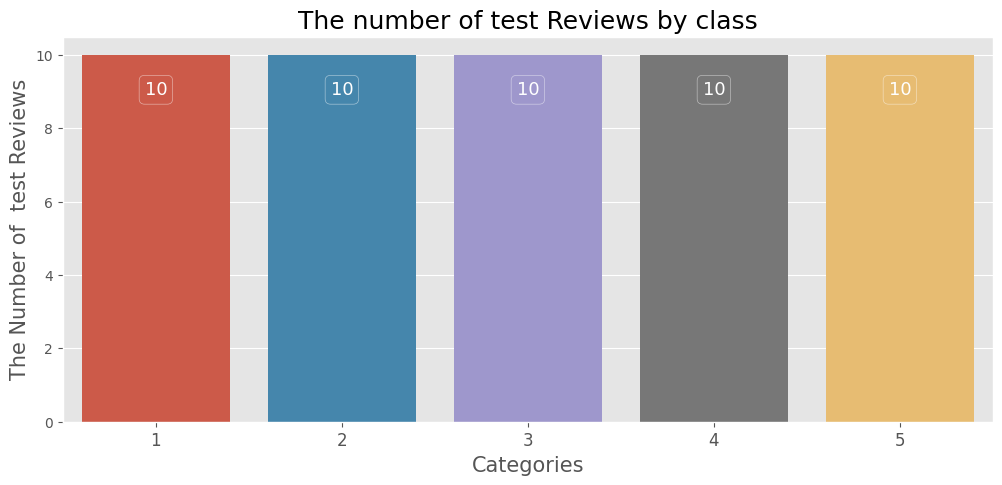

In [ ]:
columns_to_read = ['Id', 'Score', 'Text']
dftest = pd.read_csv("test.csv", usecols=columns_to_read)

category_count = dftest['Score'].value_counts()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

sns.barplot(x=category_count.index, y=category_count)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), xy=(p.get_x() + p.get_width() / 2.0, p.get_height()),
                xytext=(0, -25), size=13, color='white', ha='center', va='center',
                textcoords='offset points', bbox=dict(boxstyle='round', facecolor='none', edgecolor='white', alpha=0.5))

plt.xlabel('Categories', size=15)
plt.ylabel('The Number of  test Reviews', size=15)
plt.xticks(size=12)
plt.title("The number of test Reviews by class", size=18)
plt.show()


In [ ]:
dftest.head()

,Id,Score,Text
0,2,1,Product arrived labeled as Jumbo Salted Peanut...
1,4,2,If you are looking for the secret ingredient i...
2,13,1,My cats have been happily eating Felidae Plati...
3,17,2,I love eating them and they are good for watch...
4,27,1,"The candy is just red , No flavor . Just plan..."


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:

res = {}
for i, row in tqdm(dftest.iterrows(), total=len(dftest)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

res

  0%|          | 0/50 [00:00<?, ?it/s]

{2: {'vader_neg': 0.138,
  'vader_neu': 0.862,
  'vader_pos': 0.0,
  'vader_compound': -0.5664,
  'roberta_neg': 0.5089859,
  'roberta_neu': 0.45241374,
  'roberta_pos': 0.038600408},
 4: {'vader_neg': 0.0,
  'vader_neu': 1.0,
  'vader_pos': 0.0,
  'vader_compound': 0.0,
  'roberta_neg': 0.0022951253,
  'roberta_neu': 0.09021916,
  'roberta_pos': 0.90748566},
 13: {'vader_neg': 0.031,
  'vader_neu': 0.923,
  'vader_pos': 0.046,
  'vader_compound': 0.296,
  'roberta_neg': 0.46612456,
  'roberta_neu': 0.4152592,
  'roberta_pos': 0.1186162},
 17: {'vader_neg': 0.097,
  'vader_neu': 0.694,
  'vader_pos': 0.209,
  'vader_compound': 0.7481,
  'roberta_neg': 0.002922588,
  'roberta_neu': 0.013419523,
  'roberta_pos': 0.9836579},
 27: {'vader_neg': 0.128,
  'vader_neu': 0.872,
  'vader_pos': 0.0,
  'vader_compound': -0.296,
  'roberta_neg': 0.9533157,
  'roberta_neu': 0.04058289,
  'roberta_pos': 0.0061013945},
 46: {'vader_neg': 0.0,
  'vader_neu': 1.0,
  'vader_pos': 0.0,
  'vader_compound':

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(dftest, how='left')
results_df.head(50)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Score,Text
0,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,1,Product arrived labeled as Jumbo Salted Peanut...
1,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,2,If you are looking for the secret ingredient i...
2,13,0.031,0.923,0.046,0.2960,0.466125,0.415259,0.118616,1,My cats have been happily eating Felidae Plati...
3,17,0.097,0.694,0.209,0.7481,0.002923,0.013420,0.983658,2,I love eating them and they are good for watch...
4,27,0.128,0.872,0.000,-0.2960,0.953316,0.040583,0.006101,1,"The candy is just red , No flavor . Just plan..."
5,46,0.000,1.000,0.000,0.0000,0.886888,0.099254,0.013858,3,This seems a little more wholesome than some o...
6,48,0.000,0.868,0.132,0.4404,0.160329,0.338970,0.500700,3,"The flavors are good. However, I do not see a..."
7,50,0.056,0.865,0.079,0.2363,0.902134,0.087926,0.009940,3,This is the same stuff you can buy at the big ...
8,51,0.220,0.780,0.000,-0.5448,0.976355,0.020687,0.002957,1,"This oatmeal is not good. Its mushy, soft, I d..."
9,54,0.075,0.925,0.000,-0.3612,0.422658,0.500505,0.076838,3,we're used to spicy foods down here in south t...


In [ ]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              50 non-null     int64  
 1   vader_neg       50 non-null     float64
 2   vader_neu       50 non-null     float64
 3   vader_pos       50 non-null     float64
 4   vader_compound  50 non-null     float64
 5   roberta_neg     50 non-null     float64
 6   roberta_neu     50 non-null     float64
 7   roberta_pos     50 non-null     float64
 8   Score           50 non-null     int64  
 9   Text            50 non-null     object 
dtypes: float64(7), int64(2), object(1)
memory usage: 4.3+ KB


In [ ]:


# Define a function to update the vader predict column based on vader_compound value
def update_vader_predict(row):
    compound_score = row['vader_compound']

    if compound_score > 0.9:
        return 'Positive'
    elif compound_score > 0.6:
        return 'Positive'
    elif compound_score > 0.3:
        return 'Positive'
    elif compound_score > 0.05:
        return 'Positive'
    elif compound_score >= -0.05:
        return 'Neutral'
    elif compound_score >= -0.3:
        return 'Negative'
    elif compound_score >= -0.6:
        return 'Negative'
    elif compound_score >= -0.9:
        return 'Negative'
    else:
        return 'Negative'


# Define a function to determine the highest sentiment for the roberta columns
def determine_roberta_sentiment(row):
    if row['roberta_pos'] > row['roberta_neg'] and row['roberta_pos'] > row['roberta_neu']:
        return 'positive'
    elif row['roberta_neg'] > row['roberta_pos'] and row['roberta_neg'] > row['roberta_neu']:
        return 'negative'
    else:
        return 'neutral'

# Apply the functions to update columns
results_df['vader predict'] = results_df.apply(update_vader_predict, axis=1)
results_df['roberta predict'] = results_df.apply(determine_roberta_sentiment, axis=1)

# Save the modified DataFrame to an Excel file
excel_filename = 'modified_results.xlsx'
results_df.to_excel(excel_filename, index=False)

print(f"Saved modified results to '{excel_filename}'")
results_df.head()

Saved modified results to 'modified_results.xlsx'


,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Score,Text,vader predict,roberta predict
0,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,1,Product arrived labeled as Jumbo Salted Peanut...,Negative,negative
1,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,2,If you are looking for the secret ingredient i...,Neutral,positive
2,13,0.031,0.923,0.046,0.2960,0.466125,0.415259,0.118616,1,My cats have been happily eating Felidae Plati...,Positive,negative
3,17,0.097,0.694,0.209,0.7481,0.002923,0.013420,0.983658,2,I love eating them and they are good for watch...,Positive,positive
4,27,0.128,0.872,0.000,-0.2960,0.953316,0.040583,0.006101,1,"The candy is just red , No flavor . Just plan...",Negative,negative


In [ ]:
# VADER results PIVOT
pivot_table = results_df.pivot_table(index='Score', columns='vader predict', values='Id', aggfunc='count', fill_value=0)

# Print the pivot table
print(pivot_table)

vader predict  Negative  Neutral  Positive
Score                                     
1                     4        1         5
2                     3        2         5
3                     1        2         7
4                     1        0         9
5                     1        0         9


In [ ]:
# RoBERTa  results PIVOT
pivot_table = results_df.pivot_table(index='Score', columns='roberta predict', values='Id', aggfunc='count', fill_value=0)

# Print the pivot table
print(pivot_table)


roberta predict  negative  neutral  positive
Score                                       
1                       9        0         1
2                       5        2         3
3                       2        3         5
4                       0        2         8
5                       0        1         9


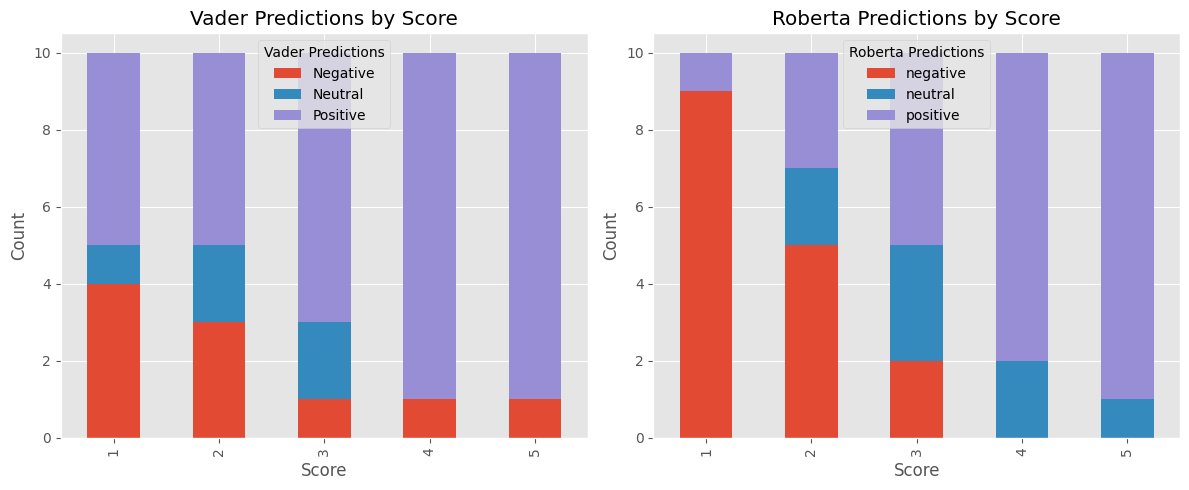

In [ ]:

# Create a DataFrame to store the counts of vader predictions for each Score
vader_prediction_counts = results_df.groupby(['Score', 'vader predict']).size().unstack(fill_value=0)

# Create a DataFrame to store the counts of roberta predictions for each Score
roberta_prediction_counts = results_df.groupby(['Score', 'roberta predict']).size().unstack(fill_value=0)

# Create subplots with two graphs in one row and two columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Vader predictions on the first subplot
vader_prediction_counts.plot(kind='bar', stacked=True, ax=axs[0])
axs[0].set_title('Vader Predictions by Score')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Count')
axs[0].legend(title='Vader Predictions')

# Plot Roberta predictions on the second subplot
roberta_prediction_counts.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_title('Roberta Predictions by Score')
axs[1].set_xlabel('Score')
axs[1].set_ylabel('Count')
axs[1].legend(title='Roberta Predictions')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


Step 4: Review Examples:
Positive 1-Star and Negative 5-Star Reviews
Lets look at some examples where the model scoring and review score differ the most.

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'This is awful.  So, I got out the pots and pans and made a great no salt, little sugar and no butter fat tomato Soup using fresh tomatoes.  Tastes much, much better than this Tomato Soup!'

As we can see thought this statment has a highest pos score but this is a sarcastic statment AND A NEGATIVE REVIEW stating tht the customer is not at all happy with the product.so roberta model failed on this review

The tqdm library offers two primary functionalities:

Progress Bar Creation: You can wrap an iterable object (e.g., list, range, data generator) with tqdm to create a progress bar. As the loop iterates through the elements, tqdm updates and displays the progress bar.

Time Estimation: tqdm also provides an estimate of the time remaining based on the current progress. It calculates the average iteration time and uses it to estimate the time needed to complete the entire process.

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'This is awful.  So, I got out the pots and pans and made a great no salt, little sugar and no butter fat tomato Soup using fresh tomatoes.  Tastes much, much better than this Tomato Soup!'

here with the vader model as well we see that their is a failure in sentiment analysis .This statment specifies that the customer was angry abt the service and used sarcasm to state that  since it was cancelled without a problem but vader classified it as a positive

# negative sentiment 5-Star view

In [ ]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

"One of my boys needed to lose some weight and the other didn't.  I put this food on the floor for the chubby guy, and the protein-rich, no by-product food up higher where only my skinny boy can jump.  The higher food sits going stale.  They both really go for this food.  And my chubby boy has been losing about an ounce a week."

The Transformers Pipeline;
*    Quick & easy way to run sentiment predictions






In [ ]:
from transformers import pipeline

# sent_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased")
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
sent_pipeline('I love sentiment analysis! its cool , really a brain racker ,so many things to take into account why does it not take the relation ship. u must be kidding')

[{'label': 'POSITIVE', 'score': 0.994724690914154}]

i just removed the , after cool and added but and the same statment changed from positive with a 0.99 score to negative 0.98

In [ ]:
sent_pipeline('I love sentiment analysis! its cool but really a brain racker ,so many things to take into account why does it not take the relation ship. u must be kidding')

[{'label': 'NEGATIVE', 'score': 0.985082745552063}]

In [ ]:
# check on previous example
sent_pipeline(example)

[{'label': 'NEGATIVE', 'score': 0.998346209526062}]

Conclusion-  VADER and RoBERTa

 VADER :

Quick Sentiment Analysis: If you need to perform sentiment analysis quickly and with minimal setup, VADER is a good choice. It's easy to implement and provides sentiment scores for short texts.

Social Media Analysis: VADER is well-suited for analyzing sentiment in social media posts, comments, and short text snippets where context and grammar may vary widely.

Real-Time Analysis: VADER's lightweight nature makes it suitable for real-time analysis of social media streams, customer feedback, and other online interactions.

Simple Interpretability: If you want a sentiment analysis tool with simple and interpretable results (positive, negative, neutral), VADER's output is straightforward.

RoBERTa:-

Resource Availability: If you have access to significant computational resources for training and fine-tuning, and a substantial amount of task-specific data, RoBERTa's performance can be maximized.

High Accuracy is Essential: If you require state-of-the-art accuracy and performance, particularly for complex language tasks.

Complex Language Understanding: When your task involves understanding complex relationships, context, and semantics in sentences, RoBERTa's contextual understanding shines.

Broad NLP Applications: If you plan to perform multiple NLP tasks such as text classification, question answering, named entity recognition, and more, RoBERTa's versatility makes it a great option.

Specialized Domains: When your task involves domain-specific language or vocabulary, fine-tuning RoBERTa for that domain can yield better results compared to general-purpose models like VADER.

